_This notebook contains code and comments from Section 5.3 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 5.3  LightGBM: A Framework for Gradient Boosting 

[LightGBM](https://lightgbm.readthedocs.io/en/latest/), or Light Gradient Boosted Machines, is an open source gradient boosting framework that was originally developed and released by Microsoft. 
At its core, LightGBM is essentially a histogram-based gradient boosting approach. However, it also has several modeling and algorithmic features that enable it to handle large-scale data. In particular, LightGBM offers the following advantages:

* Algorithmic speedups such as gradient based one-sided sampling and exclusive feature bundling that result in faster training and lower memory usage; these are described in more detail in Section 5.3.1;
* Support for a large number of loss functions for classification, regression and ranking as well as application-specific custom loss functions (Section 5.3.2);
* Support for parallel and GPU learning, which enables it handle large-scale data sets (parallel/GPU-based machine learning is out-of-scope for this book).


### 5.3.2 Gradient Boosting with LightGBM
LightGBM is available for various platforms including Windows, Linux and MacOS, and can either be built from scratch or installed using tools such as ``pip``. See the documentation of LightGBM for [installation instructions](https://lightgbm.readthedocs.io/en/latest/). Its usage syntax is quite similar to ``scikit-learn``’s. 

Continuing with the breast cancer data set from Section 5.2.3, we can learn a gradient boosting model using LightGBM as follows:

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
X, y = load_breast_cancer(return_X_y=True)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

Train a gradient boosting classifier using LightGBM

In [2]:
from lightgbm import LGBMClassifier
gbm = LGBMClassifier(boosting_type='gbdt', n_estimators=20, max_depth=1)
gbm.fit(Xtrn, ytrn)

LGBMClassifier(max_depth=1, n_estimators=20)

In [3]:
from sklearn.metrics import accuracy_score
ypred = gbm.predict(Xtst)
accuracy_score(ytst, ypred)

0.9473684210526315

---

## 5.4 LigthGBM in Practice

As with any ML algorithm, we need to ensure that we avoid overfitting during training. We look to set the learning rate (Section 5.4.1) or employ early stopping (Section 5.4.2) as a means to control overfitting. Specifically,  
* by selecting an effective learning rate, we try to control the rate at which the model learns so that it doesn’t rapidly fit, and then overfit the training data. We can think of this a proactive modeling approach, where we try to identify a good training strategy so that it leads to a good model. 
* by enforcing early stopping, we try to stop training as soon as we observe that the model is starting to overfit. We can think of this as a reactive modeling approach, where we contemplate terminating training as soon as we think we have a good model.

### 5.4.1 Learning Rate
As with AdaBoost, we can aim to avoid overfitting by training with an appropriate [learning rate](https://lightgbm.readthedocs.io/en/latest/Parameters.html#learning_rate), which adjusts the contribution of each estimator to the ensemble. ``LightGBM`` plays nicely with ``scikit-learn``, and we can combine the relevant functionalities from both packages to perform effective model learning.

LightGBM provides its own functionality to perform cross validation (CV) with given parameter choices through a function called ``cv``. 

**Listing 5.5**: Cross Validation with LightGBM and scikit-learn

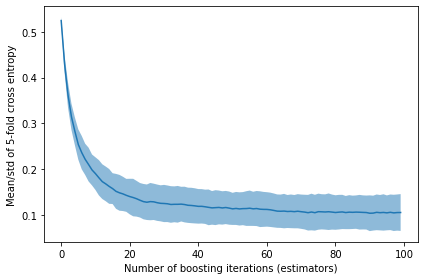

In [4]:
from lightgbm import cv, Dataset

trn_data = Dataset(Xtrn, label=ytrn)
params = {'boosting_type': 'gbdt', 'learning_rate': 0.25, 
          'max_depth': 1, 'objective': 'cross_entropy'}

cv_results = cv(params, trn_data, 
                num_boost_round=100,
                nfold=5, stratified=True, shuffle=True)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
m = np.array(cv_results['cross_entropy-mean'])
s = np.array(cv_results['cross_entropy-stdv'])
ax.fill_between(range(100), m + s, m - s, alpha=0.5)
ax.plot(range(100), m)
ax.set_xlabel('Number of boosting iterations (estimators)')
ax.set_ylabel('Mean/std of 5-fold cross entropy');

fig.tight_layout()
pngFile = './figures/CH05_F19_Kunapuli.png'
plt.savefig(pngFile, dpi=300, pad_inches=0)

Alternately, LightGBM plays nicely with scikit-learn, and we can combine the relevant functionalities from both packages to perform effective model learning.

In the experiment below, we combine ``scikit-learn``'s [``StratifiedKFold``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) class to split the training data into several folds of training and validation sets. ``StratifiedKFold`` ensures that we preserve class distributions, that is, the fractions of different classes across the folds.

**Listing 5.4**: Cross Validation with LightGBM and scikit-learn

In [5]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize choices of learning rates, number of cross-validation folds
n_learning_rate_steps, n_folds = 10, 10
learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps)

# Split the data into training and validation folds
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize some structures to save training and validation errors
trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))

# Train LightGBM classifier for different learning rates and plot the results
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(X, y)):
        gbm = LGBMClassifier(boosting_type='gbdt', n_estimators=10, max_depth=1, learning_rate=rate)
        gbm.fit(X[trn, :], y[trn])

        trn_err[i, j] = (1 - accuracy_score(y[trn], gbm.predict(X[trn, :]))) * 100
        val_err[i, j] = (1 - accuracy_score(y[val], gbm.predict(X[val, :]))) * 100

        
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

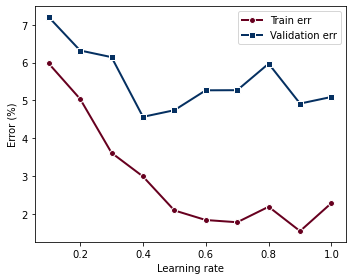

In [6]:
import matplotlib.pyplot as plt
from visualization import get_colors
cm = get_colors(colormap='RdBu', n_colors=2)

%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

ax.plot(learning_rates, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(learning_rates, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Learning rate')
ax.set_ylabel('Error (%)')

fig.tight_layout()
pngFile = './figures/CH05_F18_Kunapuli.png'
plt.savefig(pngFile, dpi=300, pad_inches=0)

### 5.4.2	Early Stopping

As with AdaBoost, the other important consideration for practical boosting is the number of base learners, which can be hard to specifiy ahead of time. Identifying the least number of base estimators in order to build an effective ensemble is known as early stopping. 

[Early stopping](https://lightgbm.readthedocs.io/en/latest/Parameters.html#early_stopping_round) with ``LightGBM`` works slightly differently than AdaBoost. In ``LightGBM``, we specify a value for the parameter ``early_stopping_rounds``. As long as the overall score (say accuracy) improves over the last ``early_stopping_rounds``, ``LightGBM`` will continue to train. However, when the score does not improve after ``early_stopping_rounds``, ``LightGBM`` stops.

Small values of ``early_stopping_rounds`` make ``LightGBM`` very "impatient" and aggressive in that it does not wait too long to see if there is any improvement before stopping learning early. This may lead to underfitting. Large values of ``early_stopping_rounds`` make ``LightGBM`` overly patient and too passive in that it waits for longer periods to see if there is any improvement. This may lead to overfitting.

``LightGBM`` needs us to **explicitly specify a validation set as well as [scoring metric](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric)**. In the experiment below, we split the training data further into a smaller training set and a separate validation set for early stopping. The metric we will use is accuracy score.

**Listing 5.6**: Early Stopping with LightGBM

In [7]:
# Create a single split of training and validation sets
Xtrn, Xval, ytrn, yval = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
gbm = LGBMClassifier(boosting_type='gbdt', n_estimators=50, max_depth=1, early_stopping=5)
gbm.fit(Xtrn, ytrn, eval_set=[(Xval, yval)], eval_metric='auc')

[1]	valid_0's auc: 0.885522	valid_0's binary_logloss: 0.602321
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.961022	valid_0's binary_logloss: 0.542925
[3]	valid_0's auc: 0.96528	valid_0's binary_logloss: 0.497678
[4]	valid_0's auc: 0.989846	valid_0's binary_logloss: 0.451922
[5]	valid_0's auc: 0.986243	valid_0's binary_logloss: 0.421817
[6]	valid_0's auc: 0.985588	valid_0's binary_logloss: 0.393713
[7]	valid_0's auc: 0.989846	valid_0's binary_logloss: 0.364781
[8]	valid_0's auc: 0.990501	valid_0's binary_logloss: 0.338063
[9]	valid_0's auc: 0.989191	valid_0's binary_logloss: 0.319267
[10]	valid_0's auc: 0.990501	valid_0's binary_logloss: 0.299509
[11]	valid_0's auc: 0.989519	valid_0's binary_logloss: 0.286114
[12]	valid_0's auc: 0.989519	valid_0's binary_logloss: 0.269481
[13]	valid_0's auc: 0.992303	valid_0's binary_logloss: 0.255033
[14]	valid_0's auc: 0.993285	valid_0's binary_logloss: 0.241218
[15]	valid_0's auc: 0.992958	valid_0's binary_logloss:

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(early_stopping=5, max_depth=1, n_estimators=50)

We also visualize the training and validation errors as well as the ensemble size for different choices of early_stopping_rounds.

In [9]:
number_of_steps = np.arange(1, 10, 1)


trn_err = np.zeros((len(number_of_steps), ))
val_err = np.zeros((len(number_of_steps), ))
n_iters = np.zeros((len(number_of_steps), ))

for i, rounds in enumerate(number_of_steps):
    gbm = LGBMClassifier(boosting_type='gbdt', n_estimators=50, max_depth=1, early_stopping=rounds)
    gbm.fit(Xtrn, ytrn, eval_set=[(Xval, yval)], eval_metric='auc')
                     
    trn_err[i] = 1 - accuracy_score(ytrn,  gbm.predict(Xtrn))
    val_err[i] = 1 - accuracy_score(yval,  gbm.predict(Xval))
    n_iters[i] = len(gbm.evals_result_['valid_0']['auc']) # Get the number of estimators in the ensemble in a roundabout way  

[1]	valid_0's auc: 0.885522	valid_0's binary_logloss: 0.602321
Training until validation scores don't improve for 1 rounds
[2]	valid_0's auc: 0.961022	valid_0's binary_logloss: 0.542925
[3]	valid_0's auc: 0.96528	valid_0's binary_logloss: 0.497678
[4]	valid_0's auc: 0.989846	valid_0's binary_logloss: 0.451922
[5]	valid_0's auc: 0.986243	valid_0's binary_logloss: 0.421817
Early stopping, best iteration is:
[4]	valid_0's auc: 0.989846	valid_0's binary_logloss: 0.451922
[1]	valid_0's auc: 0.885522	valid_0's binary_logloss: 0.602321
Training until validation scores don't improve for 2 rounds
[2]	valid_0's auc: 0.961022	valid_0's binary_logloss: 0.542925
[3]	valid_0's auc: 0.96528	valid_0's binary_logloss: 0.497678
[4]	valid_0's auc: 0.989846	valid_0's binary_logloss: 0.451922
[5]	valid_0's auc: 0.986243	valid_0's binary_logloss: 0.421817
[6]	valid_0's auc: 0.985588	valid_0's binary_logloss: 0.393713
Early stopping, best iteration is:
[4]	valid_0's auc: 0.989846	valid_0's binary_logloss: 0.

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

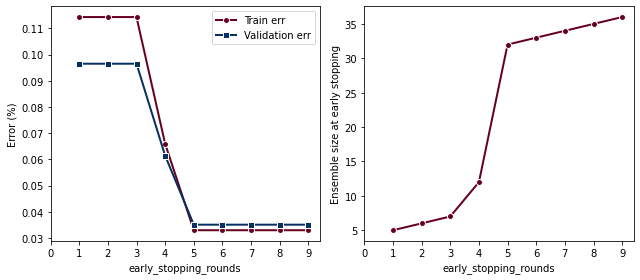

In [10]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(number_of_steps, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax[0].plot(number_of_steps, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax[0].legend(['Train err', 'Validation err'])
ax[0].set_xlabel('early_stopping_rounds')
ax[0].set_ylabel('Error (%)')
ax[0].set_xticks(range(10))

ax[1].plot(number_of_steps, n_iters, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax[1].set_xlabel('early_stopping_rounds')
ax[1].set_ylabel('Ensemble size at early stopping')
ax[1].set_xticks(range(10))

fig.tight_layout()
pngFile = './figures/CH05_F20_Kunapuli.png'
plt.savefig(pngFile, dpi=300, pad_inches=0)

### 5.4.3. Custom Loss Functions
The **training loss** is the function that is optimized during training. Recall that we used squared error as the loss while building our own gradient boosting algorithm; ``LightGBM`` uses cross-entropy, otherwise known as the logistic loss. 

The **focal loss** is a new loss function introduced by [Lin et al.](https://arxiv.org/abs/1708.02002) for object detection. It is a modification of the classical cross-entropy loss that puts more focus on harder-to-classify examples, while ignoring the easier examples. The extent of this "focus" is determined by a user-controllable parameter, $\gamma \geq 0$.

Let's define the model's predicted probability of $y_{pred} = 1$ as $p$. For a binary classification problem, since the only other label is $y=0$, the probability of $y_{pred} = 0$ will be $1-p$. The classical cross-entropy loss (for binary classification) is:

\\[
L(y_{true}, y_{pred}) = - y_{true} \log{p} -  (1 - y_{true}) \log{(1 - p)}.
\\]

The focal loss introduces a **modulating factor** to each term:

\\[
L(y_{true}, y_{pred}) = - (1 - y_{true}) p^\gamma \log{(1 - p)} -  y_{true} (1 - p)^\gamma \log{p}.
\\]

The modulating factor essentially suppresses the contribution of well-classified examples, forcing the algorithm that uses this loss to learn a model that focuses on poorly-classified examples. This effect can be seen below, where the focal loss is plotted for different values of $\gamma$.

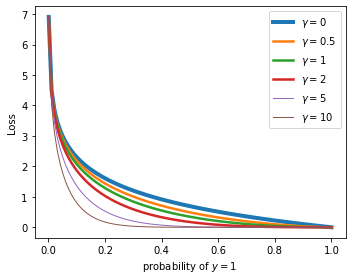

In [11]:
%matplotlib inline 

p = np.linspace(0.001, 1.0, num=100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

for g in [0, 0.5, 1, 2, 5, 10]:
    f = -(1 - p)**g * np.log(p)
    
    if g == 0.0:
        ax.plot(p, f, linewidth=4)
    elif 0.5 <= g < 5:
        ax.plot(p, f, linewidth=2.5)
    else:
        ax.plot(p, f, linewidth=1)
        
ax.set_xlabel('probability of $y = 1$')
ax.set_ylabel('Loss')
ax.legend(['$\gamma = {0}$'.format(g) for g in [0, 0.5, 1, 2, 5, 10]])

fig.tight_layout()
pngFile = './figures/CH05_F21_Kunapuli.png'
plt.savefig(pngFile, dpi=300, pad_inches=0)

When $\gamma=0$, the original cross-entropy loss is recovered. As $\gamma$ increases, the part of the curve corresponding to "well-classified" examples becomes longer, reflecting the loss function's focus on poor classification.

In order to use this focal loss to train gradient boosted decision trees, we have to provide ``LightGBM`` with two functions:
* the actual loss function itself, which can be used for evaluation
* the first derivative (gradient) and second derivative (Hessian), which will be used for learning

**Listing 5.7**: Defining Custom Loss Functions

In [12]:
from scipy.misc import derivative

def focal_loss(ytrue, ypred, gamma=2.0):   
    p = 1 / (1 + np.exp(-ypred))
    loss = -(1 - ytrue) * p**gamma * np.log(1 - p) - ytrue * (1 - p)**gamma * np.log(p)
    return loss


def focal_loss_metric(ytrue, ypred):
    return 'focal_loss_metric', np.mean(focal_loss(ytrue, ypred)), False


def focal_loss_objective(ytrue, ypred):
    func = lambda z: focal_loss(ytrue, z)
    grad = derivative(func, ypred, n=1, dx=1e-6)
    hess = derivative(func, ypred, n=2, dx=1e-6)
    return grad, hess

In [13]:
gbm_focal_loss = LGBMClassifier(objective=focal_loss_objective, learning_rate=0.25, n_estimators=20, max_depth=1)
gbm_focal_loss.fit(Xtrn, ytrn, eval_set=[(Xval, yval)], eval_metric=focal_loss_metric)
accuracy_score(yval, gbm_focal_loss.predict(Xval))

[1]	valid_0's focal_loss_metric: 0.141808
[2]	valid_0's focal_loss_metric: 0.11333
[3]	valid_0's focal_loss_metric: 0.0952922
[4]	valid_0's focal_loss_metric: 0.0790233
[5]	valid_0's focal_loss_metric: 0.0677255
[6]	valid_0's focal_loss_metric: 0.0606197
[7]	valid_0's focal_loss_metric: 0.0537766
[8]	valid_0's focal_loss_metric: 0.0482069
[9]	valid_0's focal_loss_metric: 0.0459177
[10]	valid_0's focal_loss_metric: 0.0438938
[11]	valid_0's focal_loss_metric: 0.0396912
[12]	valid_0's focal_loss_metric: 0.0373091
[13]	valid_0's focal_loss_metric: 0.0354938
[14]	valid_0's focal_loss_metric: 0.0325854
[15]	valid_0's focal_loss_metric: 0.0325117
[16]	valid_0's focal_loss_metric: 0.0321897
[17]	valid_0's focal_loss_metric: 0.03054
[18]	valid_0's focal_loss_metric: 0.0303324
[19]	valid_0's focal_loss_metric: 0.0283734
[20]	valid_0's focal_loss_metric: 0.0272042


0.9736842105263158

In [14]:
gbm_standard = LGBMClassifier(boosting_type='gbdt', learning_rate=0.25, n_estimators=20, max_depth=1)
gbm_standard.fit(Xtrn, ytrn)
accuracy_score(yval, gbm_standard.predict(Xval))

0.956140350877193